# Convolutional Neural Network

- https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/02-intermediate/convolutional_neural_network/main.py#L33-L53

- ここからGPUを使う
- MNISTとCIFAR10
- CNNはブロック単位で処理した方がよいのでSequentialを使う
- Conv2dはKerasと違って入力のユニットサイズも省略できない
- 自分で計算 or モデルの途中結果サイズをprintしてみる

## MNIST

In [2]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable

In [3]:
# Hyperparameters 
num_epochs = 10
batch_size = 100
learning_rate = 0.001

- GPUが使えるか使えないか確認
- 使える場合は自動的にGPU上で動かす

In [4]:
use_gpu = torch.cuda.is_available()
if use_gpu:
    print('cuda is available!')

In [5]:
# MNIST Dataset (Images and Labels)
train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

# Dataset Loader (Input Pipline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [14]:
class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(7 * 7 * 32, 10)
        
    def forward(self, x):
        print('1:', x.size())
        out = self.layer1(x)
        print('2:', out.size())
        out = self.layer2(out)
        print('3:', out.size())
        out = out.view(out.size(0), -1)
        print('4:', out.size())
        out = self.fc(out)
        print('5:', out.size())
        return out

- 最後のLinearのユニット数がわからなければ途中結果をprintしてみる
- 7 x 7 x 32 = 1568

- GPUモードで動かすには
- モデルとテンソルデータを`cuda()`でGPUに転送する！

In [10]:
model = CNN()
if use_gpu:
    model.cuda()

In [15]:
print(model)

CNN(
  (layer1): Sequential(
    (0): Conv2d (1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (layer2): Sequential(
    (0): Conv2d (16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (fc): Linear(in_features=1568, out_features=10)
)


In [13]:
# テスト
model = CNN()
images, labels = iter(train_loader).next()
print(images.size())
outputs = model(Variable(images))

torch.Size([100, 1, 28, 28])
1: torch.Size([100, 1, 28, 28])
2: torch.Size([100, 16, 14, 14])
3: torch.Size([100, 32, 7, 7])
4: torch.Size([100, 1568])
5: torch.Size([100, 10])


In [46]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

- BatchNormalizationを使っている場合はモデルのモードが重要
- `model.train()` で訓練モード
- `model.eval()` で評価モード

In [ ]:
def train(train_loader):
    model.train()
    running_loss = 0
    for batch_idx, (images, labels) in enumerate(train_loader):
        if use_gpu:
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())
        else:
            images = Variable(images)
            labels = Variable(labels)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        running_loss += loss.data[0]

        loss.backward()
        optimizer.step()

    train_loss = running_loss / len(train_loader)
    
    return train_loss


def valid(test_loader):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0
    for batch_idx, (images, labels) in enumerate(test_loader):
        if use_gpu:
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())
        else:
            images = Variable(images)
            labels = Variable(labels)

        outputs = model(images)

        loss = criterion(outputs, labels)
        running_loss += loss.data[0]

        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels.data).sum()
        total += labels.size(0)

    val_loss = running_loss / len(test_loader)
    val_acc = correct / total
    
    return val_loss, val_acc


loss_list = []
val_loss_list = []
val_acc_list = []
for epoch in range(num_epochs):
    loss = train(train_loader)
    val_loss, val_acc = valid(test_loader)

    print('epoch %d, loss: %.4f val_loss: %.4f val_acc: %.4f'
          % (epoch, loss, val_loss, val_acc))
    
    # logging
    loss_list.append(loss)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

# save the trained model
np.save('loss_list.npy', np.array(loss_list))
np.save('val_loss_list.npy', np.array(val_loss_list))
np.save('val_acc_list.npy', np.array(val_acc_list))
torch.save(model.state_dict(), 'cnn.pkl')

```
cuda is available!
epoch 0, loss: 0.1666 val_loss: 0.0549 val_acc: 0.9824
epoch 1, loss: 0.0487 val_loss: 0.0372 val_acc: 0.9875
epoch 2, loss: 0.0369 val_loss: 0.0283 val_acc: 0.9905
epoch 3, loss: 0.0295 val_loss: 0.0359 val_acc: 0.9884
epoch 4, loss: 0.0247 val_loss: 0.0302 val_acc: 0.9904
epoch 5, loss: 0.0194 val_loss: 0.0402 val_acc: 0.9871
epoch 6, loss: 0.0161 val_loss: 0.0298 val_acc: 0.9903
epoch 7, loss: 0.0133 val_loss: 0.0351 val_acc: 0.9883
epoch 8, loss: 0.0123 val_loss: 0.0307 val_acc: 0.9909
epoch 9, loss: 0.0104 val_loss: 0.0242 val_acc: 0.9926
```

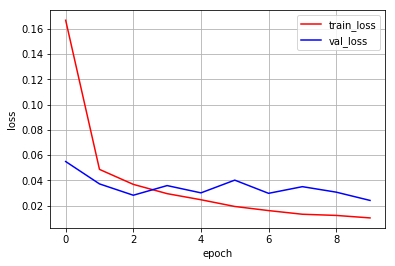

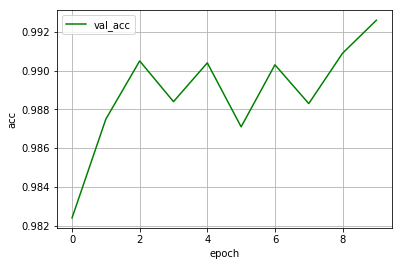

In [50]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

loss_list = np.load('loss_list.npy')
val_loss_list = np.load('val_loss_list.npy')
val_acc_list = np.load('val_acc_list.npy')

# plot learning curve
plt.figure()
plt.plot(range(num_epochs), loss_list, 'r-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, 'b-', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), val_acc_list, 'g-', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.grid()

- ほぼ最初のエポックで98%を超えるレベル

## CIFAR-10

- http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py

In [100]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable

In [101]:
use_gpu = torch.cuda.is_available()
if use_gpu:
    print('cuda is available!')

In [102]:
num_epochs = 30
batch_size = 128

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # [0, 1] => [-1, 1]
])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                         download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                           shuffle=True, num_workers=4)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                          shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


データ表示テスト

- http://pytorch.org/docs/master/torchvision/utils.html#torchvision.utils.make_grid

(-0.5, 132.5, 132.5, -0.5)

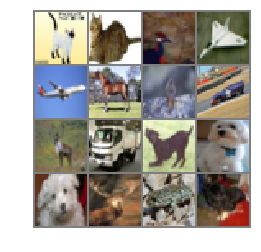

In [103]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def imshow(img):
    # unnormalize [-1, 1] => [0, 1]
    img = img / 2 + 0.5
    npimg = img.numpy()
    # [c, h, w] => [h, w, c]
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

images, labels = iter(train_loader).next()
images, labels = images[:16], labels[:16]
imshow(torchvision.utils.make_grid(images, nrow=4, padding=1))
plt.axis('off')

In [104]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
#         print('1:', x.size())
        x = self.pool(F.relu(self.conv1(x)))
#         print('2:', x.size())
        x = self.pool(F.relu(self.conv2(x)))
#         print('3:', x.size())
        x = x.view(-1, 16 * 5 * 5)
#         print('4:', x.size())
        x = F.relu(self.fc1(x))
#         print('5:', x.size())
        x = F.relu(self.fc2(x))
#         print('6:', x.size())
        x = self.fc3(x)
#         print('7:', x.size())
        return x

In [105]:
model = CNN()
if use_gpu:
    model.cuda()

In [106]:
model

CNN(
  (conv1): Conv2d (3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2): Conv2d (6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120)
  (fc2): Linear(in_features=120, out_features=84)
  (fc3): Linear(in_features=84, out_features=10)
)

In [107]:
images, labels = iter(train_loader).next()
outputs = model(Variable(images))

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def train(train_loader):
    model.train()
    running_loss = 0
    for i, (images, labels) in enumerate(train_loader):
        if use_gpu:
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())
        else:
            images = Variable(images)
            labels = Variable(labels)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        running_loss += loss.data[0]

        loss.backward()
        optimizer.step()

    train_loss = running_loss / len(train_loader)

    return train_loss


def valid(test_loader):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(test_loader):
        if use_gpu:
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())
        else:
            images = Variable(images)
            labels = Variable(labels)

        outputs = model(images)

        loss = criterion(outputs, labels)
        running_loss += loss.data[0]

        _, predicted = torch.max(outputs.data, 1)
        if use_gpu:
            correct += (predicted.cpu() == labels.cpu().data).sum()
        else:
            correct += (predicted == labels.data).sum()
        total += labels.size(0)

    val_loss = running_loss / len(test_loader)
    val_acc = correct / total

    return val_loss, val_acc


loss_list = []
val_loss_list = []
val_acc_list = []
for epoch in range(num_epochs):
    loss = train(train_loader)
    val_loss, val_acc = valid(test_loader)

    print('epoch %d, loss: %.4f val_loss: %.4f val_acc: %.4f'
          % (epoch, loss, val_loss, val_acc))

    # logging
    loss_list.append(loss)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

print('Finished training')

# save the trained model
np.save('loss_list.npy', np.array(loss_list))
np.save('val_loss_list.npy', np.array(val_loss_list))
np.save('val_acc_list.npy', np.array(val_acc_list))
torch.save(model.state_dict(), 'cnn.pkl')

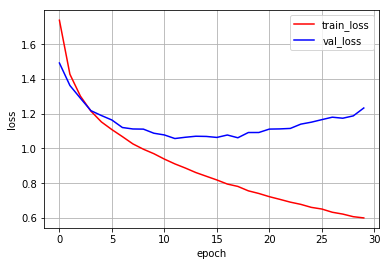

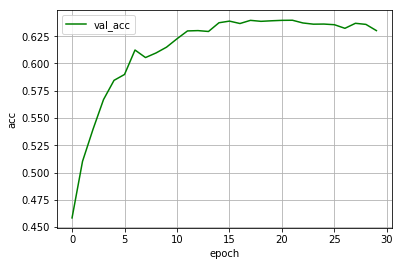

In [109]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

loss_list = np.load('loss_list.npy')
val_loss_list = np.load('val_loss_list.npy')
val_acc_list = np.load('val_acc_list.npy')

# plot learning curve
plt.figure()
plt.plot(range(num_epochs), loss_list, 'r-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, 'b-', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), val_acc_list, 'g-', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.grid()